### Learning Assignment
1.	Explore Kaggle API
2.	Plot how #users grew over time (since 2010) using Kaggle API
3.	Plot top 5 countries based on #users from that country as a bar chart
a.	Also, plot how numbers of users grew over time for each of these countries
4.	Plot top 10 countries with GMs as a bar chart
5.	Plot top 10 competition tags and the number of competitions associated with those
a.	Also, plot (over time) the number of competition associated with each of these tags.

### 1. Explore Kaggle API
References:
- https://www.kaggle.com/donkeys/kaggle-python-api
- https://github.com/Kaggle/kaggle-api
- https://www.kaggle.com/steubk/a-meta-kaggler-s-guide-to-kaggle
- https://www.kaggle.com/kaggle/meta-kaggle

Git Hub Repo:
- https://github.com/vgtgayan/ExploreKaggleMetaData/tree/master

In [2]:
# pip install kaggle

In [3]:
# import kaggle
from kaggle.api.kaggle_api_extended import KaggleApi

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
kapi = KaggleApi()
kapi.authenticate()
# print(kapi.get_config_value('username'))

In [5]:
!kaggle datasets list -s "Users.csv"

ref                                                        title                                  size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  ------------------------------------  -----  -------------------  -------------  ---------  ---------------  
vikasg/russian-troll-tweets                                Russian Troll Tweets                   21MB  2018-02-15 00:49:04           3635        138  0.7352941        
sharthz23/mts-library                                      MTS Library                            15MB  2020-10-08 05:03:25            442         19  1.0              
jtrotman/user-achievements-snapshots                       User Achievements Snapshots            44MB  2021-10-02 10:58:09             13          4  1.0              
arashnic/book-recommendation-dataset                       Book Recommendation Dataset            24MB  2020-11-29 01:29:41           4659         70  1.0 

In [6]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         90           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes         93           False  
store-sales-time-series-forecasting            2030-06-30 23:59:00  Getting Started  Knowledge        954           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        158           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       1751           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      14397           False  
house-pr

Below is the command to download kaggle meta data set (17GB)

In [7]:
# !kaggle datasets download -d kaggle/meta-kaggle

#### Read users csv file into pandas data frame

In [8]:
df = pd.read_csv("Users.csv")
df.head()

,Id,UserName,DisplayName,RegisterDate,PerformanceTier
0,1,kaggleteam,Kaggle Team,03/24/2011,5
1,368,antgoldbloom,Anthony Goldbloom,01/20/2010,5
2,381,iguyon,Isabelle,01/29/2010,2
3,383,davidstephan,David Stephan,02/01/2010,0
4,384,gabewarren,Gabe Warren,02/02/2010,0


In [9]:
df.shape

(8481954, 5)

In [10]:
# Check for null values
df.isnull().sum()

Id                   0
UserName             1
DisplayName        219
RegisterDate         0
PerformanceTier      0
dtype: int64

In [12]:
# Data type conversions
df['RegisterDate'] = df['RegisterDate'].astype('datetime64[ns]')
# df['RegisterDate'] = pd.to_datetime(df['RegisterDate'],format='%m%d%Y')
df[:5]

,Id,UserName,DisplayName,RegisterDate,PerformanceTier
0,1,kaggleteam,Kaggle Team,2011-03-24,5
1,368,antgoldbloom,Anthony Goldbloom,2010-01-20,5
2,381,iguyon,Isabelle,2010-01-29,2
3,383,davidstephan,David Stephan,2010-02-01,0
4,384,gabewarren,Gabe Warren,2010-02-02,0


### 2.	Plot how #users grew over time (since 2010) using Kaggle API

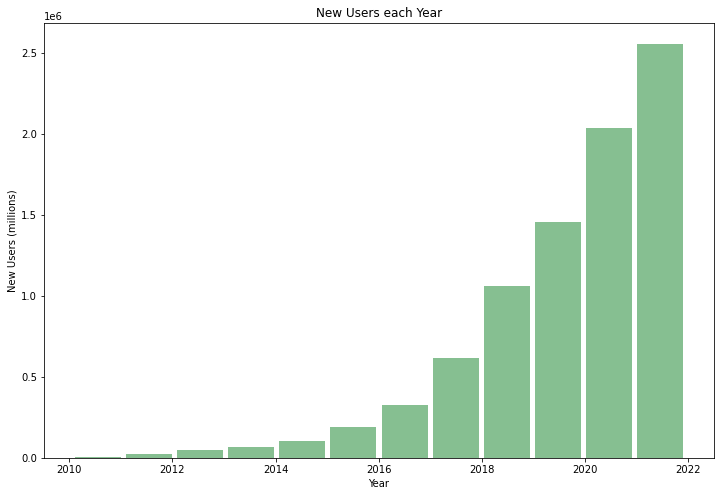

In [13]:
df.hist(column='RegisterDate', bins=12, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
plt.title('New Users each Year')
plt.ylabel('New Users (millions)')
plt.xlabel('Year')
plt.show()

Obtain registered year from 'RegisterDate'

In [14]:
df['RegisterYear'] = pd.DatetimeIndex(df['RegisterDate']).year
df[:5]

,Id,UserName,DisplayName,RegisterDate,PerformanceTier,RegisterYear
0,1,kaggleteam,Kaggle Team,2011-03-24,5,2011
1,368,antgoldbloom,Anthony Goldbloom,2010-01-20,5,2010
2,381,iguyon,Isabelle,2010-01-29,2,2010
3,383,davidstephan,David Stephan,2010-02-01,0,2010
4,384,gabewarren,Gabe Warren,2010-02-02,0,2010


Plot 'RegisterYear' histogram

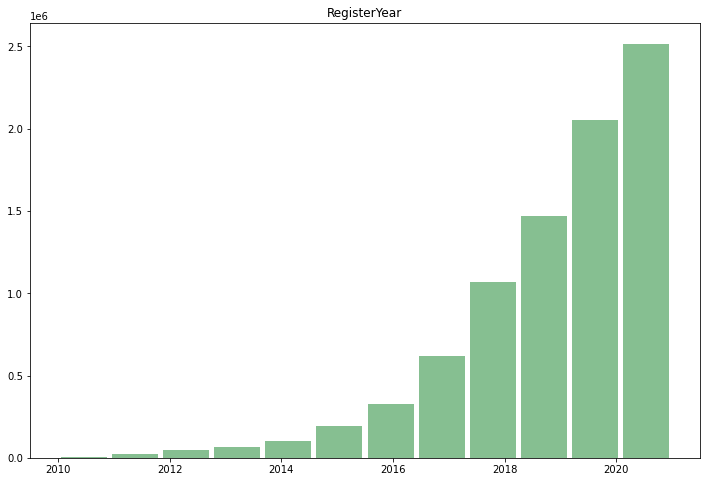

In [16]:
df.hist(column='RegisterYear', bins=12, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
plt.show()

Group by 'RegisterYear' to obtain the total no: of new user per year

In [17]:
users_by_year_df = df.groupby(['RegisterYear']).size().reset_index(name='UsersPerYear')
users_by_year_df[:]

,RegisterYear,UsersPerYear
0,2010,4521
1,2011,20836
2,2012,45977
3,2013,65738
4,2014,101241
5,2015,193583
6,2016,325414
7,2017,618915
8,2018,1068659
9,2019,1467369


Added new field 'TotalUsers' to record the cumulative sum of users by year

In [18]:
users_by_year_df['TotalUsers'] = users_by_year_df['UsersPerYear']
tot_users = 0
for i,j in users_by_year_df.iterrows():
    # print(j.UsersPerYear)
    tot_users += j.UsersPerYear
    users_by_year_df['TotalUsers'].iloc[i] = tot_users

users_by_year_df[:]

,RegisterYear,UsersPerYear,TotalUsers
0,2010,4521,4521
1,2011,20836,25357
2,2012,45977,71334
3,2013,65738,137072
4,2014,101241,238313
5,2015,193583,431896
6,2016,325414,757310
7,2017,618915,1376225
8,2018,1068659,2444884
9,2019,1467369,3912253


Plot the 'TotalUsers' against the 'RegisterYear'

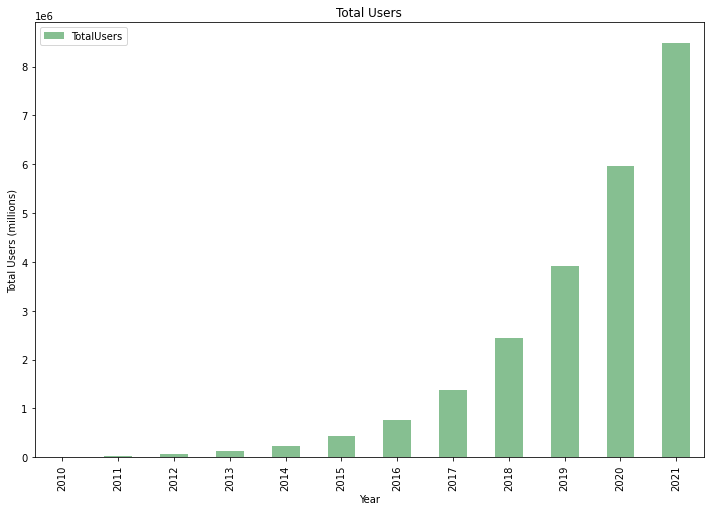

In [22]:
users_by_year_df.plot.bar(x='RegisterYear', y='TotalUsers', figsize=(12,8), color='#86bf91')
plt.title('Total Users')
plt.ylabel('Total Users (millions)')
plt.xlabel('Year')
plt.show()

### 3.	Plot top 5 countries based on #users from that country as a bar chart